In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Load Data
data = pd.read_csv('/home/semre/brent_oil_price_analysis/data/Copy of BrentOilPrices.csv')
data['Date'] = pd.to_datetime(data['Date'], format='mixed', dayfirst=True)
data.set_index('Date', inplace=True)

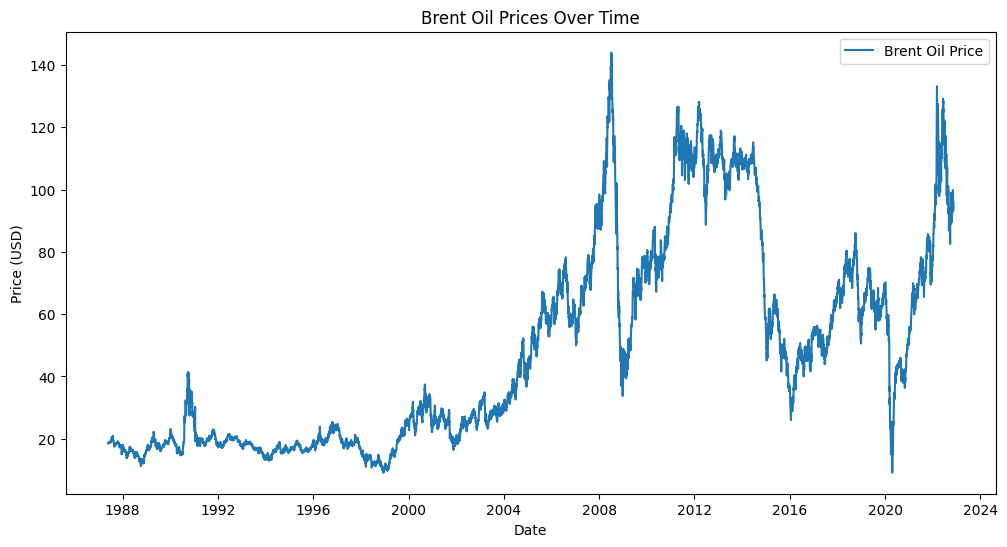

In [5]:
# EDA - Plotting the Price Time Series
plt.figure(figsize=(12, 6))
plt.plot(data['Price'], label='Brent Oil Price')
plt.title('Brent Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [6]:
# Check for missing values
print("Missing Values:\n", data.isna().sum())

Missing Values:
 Price    0
dtype: int64


In [7]:
# Impute or Drop Missing Values if needed
data.dropna(inplace=True)

In [8]:
# Define function for tagging events (example)
def tag_events(data, event_dates, event_name):
    """Tag event periods in the dataset."""
    data[event_name] = 0
    for date in event_dates:
        data.loc[data.index == pd.to_datetime(date), event_name] = 1
    return data

In [9]:
# Adding event labels
conflict_dates = ['2022-02-24']
data = tag_events(data, conflict_dates, 'Conflict')

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 9011
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -14543.950
Date:                Thu, 31 Oct 2024   AIC                          29093.899
Time:                        10:13:58   BIC                          29115.218
Sample:                             0   HQIC                         29101.153
                               - 9011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3427      0.159     -2.152      0.031      -0.655      -0.031
ma.L1          0.3712      0.157      2.358      0.018       0.063       0.680
sigma2         1.4777      0.008    184.571      0.0

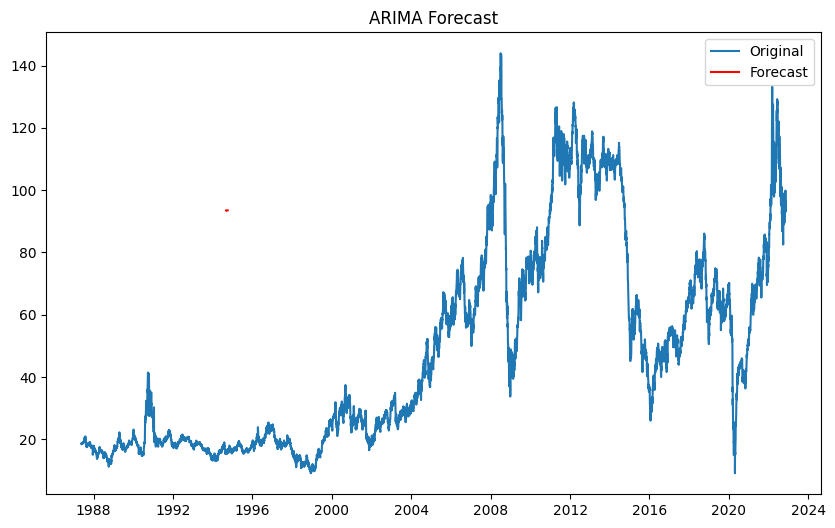

In [10]:
# ARIMA Model for Trend Analysis
def arima_model(data):
    model = ARIMA(data['Price'], order=(1, 1, 1))  # Example order, tune as needed
    arima_fit = model.fit()
    print(arima_fit.summary())
    
    # Forecast
    forecast = arima_fit.forecast(steps=30)  # Forecasting next 30 days
    plt.figure(figsize=(10, 6))
    plt.plot(data['Price'], label='Original')
    plt.plot(forecast, label='Forecast', color='red')
    plt.title('ARIMA Forecast')
    plt.legend()
    plt.show()
    return arima_fit

arima_fit = arima_model(data)

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -19268.8
Distribution:                  Normal   AIC:                           38545.6
Method:            Maximum Likelihood   BIC:                           38574.0
                                        No. Observations:                 9010
Date:                Thu, Oct 31 2024   Df Residuals:                     9009
Time:                        10:14:19   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0605  1.939e-02      3.119  1.815e-03 [2.

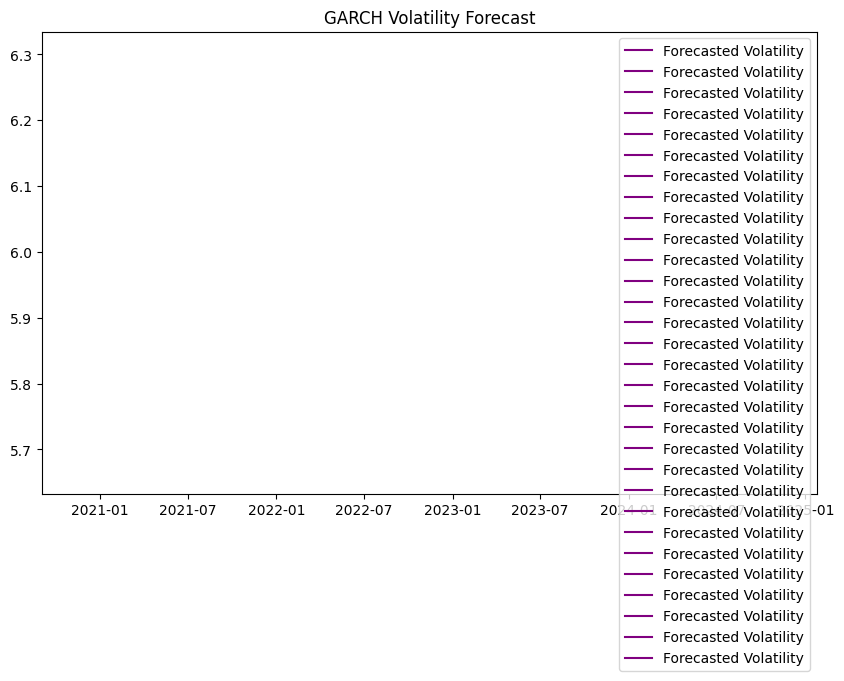

In [11]:
# GARCH Model for Volatility Analysis
def garch_model(data):
    returns = data['Price'].pct_change().dropna() * 100  # Calculate returns in %
    model = arch_model(returns, vol='Garch', p=1, q=1)
    garch_fit = model.fit(disp="off")
    print(garch_fit.summary())
    
    # Forecast Volatility
    forecast = garch_fit.forecast(horizon=30)
    plt.figure(figsize=(10, 6))
    plt.plot(forecast.variance[-1:], label='Forecasted Volatility', color='purple')
    plt.title('GARCH Volatility Forecast')
    plt.legend()
    plt.show()
    return garch_fit

garch_fit = garch_model(data)

In [12]:
# Event Impact Analysis 
def event_impact_analysis(data, event_name):
    event_prices = data[data[event_name] == 1]['Price']
    avg_impact = event_prices.pct_change().mean() * 100 
    print(f'Average impact of {event_name}: {avg_impact:.2f}%')
    return avg_impact

conflict_impact = event_impact_analysis(data, 'Conflict')

Average impact of Conflict: nan%
